In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [2]:
def turn_cluster_labels_to_knn(cluster_labels, uniq_labels):
    """
    """
    
    clst_idx = snmcseq_utils.get_index_from_array(uniq_labels, cluster_labels)
    m, n = len(clst_idx), len(uniq_labels)
    _i = np.arange(m)
    _j = clst_idx
    _data = [1]*m
    knn = sparse.coo_matrix((_data, (_i, _j)), shape=(m, n)) 
    return knn



In [3]:
def row_dot_product_norm_by_numcol(X_zscore, Y_zscore, x_idx, y_idx, 
                                   chunksize=100000, verbose_level=100000):
    """compute (X_zscore[x_idx]*Y_zscore[y_idx]).mean(axis=1)
    correlation values given matched x_idx and y_idx...
    """
    ti = time.time()
    
    assert len(x_idx) == len(y_idx)
    num_pairs = len(x_idx)
    corrs = []
    for pair_idx in snmcseq_utils.chunks(np.arange(num_pairs), chunksize):
        if verbose_level and pair_idx[0] % verbose_level == 0:
            print(pair_idx[0], time.time()-ti)

        _res = (X_zscore[x_idx[pair_idx]]*Y_zscore[y_idx[pair_idx]]).mean(axis=1)
        corrs.append(_res)
    corrs = np.hstack(corrs) 
    return corrs 

In [4]:
def compute_enh_gene_corrs(gc_rna, ec_mccg, 
    enhancer_gene_to_eval, 
    common_genes, common_enhancers,
    output_file='', **kwargs,
    ):
    """
    gc_rna: enh-by-cell RNA matrix
    ec_mccg: enh-by-cell mC matrix
    enhancer_gene_to_eval: a table with enhancer-gene pairs need to be ...
    
    common_genes: orders gene in the mat gc_rna
    common_enhancers: orders of enh in the mat ec_mccg (ec_mccg.index.values)
    
    """
    common_enhancers = ec_mccg.index.values
    
    gc_rna_zscore = stats.zscore(np.array(gc_rna), axis=1, ddof=0, nan_policy='propagate')
    ec_mccg_zscore = stats.zscore(np.array(ec_mccg), axis=1, ddof=0, nan_policy='propagate')
    
    # correlate e-g according to a e-g table
    gene_idx = snmcseq_utils.get_index_from_array(common_genes, enhancer_gene_to_eval['gene'])
    enh_idx = snmcseq_utils.get_index_from_array(common_enhancers, enhancer_gene_to_eval['ens']) # be careful here!
    to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)
    
    gene_idx = gene_idx[to_correlate]
    enh_idx = enh_idx[to_correlate]
    
    # corr
    corrs = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx, **kwargs)
    
    # corr shuffled cells
    corrs_shuffled_cells = row_dot_product_norm_by_numcol(
        gc_rna_zscore[:,np.random.permutation(gc_rna_zscore.shape[1])], 
        ec_mccg_zscore, 
        gene_idx, enh_idx, **kwargs)

    # corr shuffled genes (break up the pairs)
    gene_idx_uniq = np.unique(gene_idx)
    shuff_genes = {
        gene: gene_shuff for gene, gene_shuff in 
            zip(gene_idx_uniq, gene_idx_uniq[np.random.permutation(len(gene_idx_uniq))])
        }
    gene_idx_shuff = np.array([shuff_genes[gene] for gene in gene_idx])

    corrs_shuffled = row_dot_product_norm_by_numcol(
        gc_rna_zscore, 
        ec_mccg_zscore, 
        gene_idx_shuff, enh_idx, **kwargs)
    
    # save corrs 
    if output_file:
        with open(output_file, 'wb') as fh:
            pickle.dump((to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells), fh)
        
    return to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells

# setup - cluster level correlation

In [5]:
today = datetime.date.today()
print(today)


output_corr = '/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_test1.pkl'.format(today)
output_figures = "/cndd2/fangming/projects/scf_enhancers/results/figures/{}_{{}}.pdf".format(today) 
# output_to_correlate = "/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_idx_test1.pkl".format(today)
# output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v1.pdf'.format(today)
# output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v2.pdf'.format(today)

2020-09-15


# Load data 

In [6]:
# enhancer-gene linkage
ti = time.time()

input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
9.28837251663208


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [7]:
# input_bundle
f = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_july29'
bundle_fnames = (
    'cell_smarter_cells.txt',
    'cell_snmcseq_gene.txt',
    'gene_smarter_cells.txt',
    'enh_snmcseq_gene.tsv',
    
    'mat_smarter_cells.npz',
    'mat_mcg_snmcseq_gene.npz',
    'mat_cg_snmcseq_gene.npz',
    'knn_smarter_cells_snmcseq_gene.npz',
    'knn_smarter_cells.npz',
)


ti = time.time()
with snmcseq_utils.cd(f):
    bundle = []
    for fname in bundle_fnames:
        #  save all as pickle file
        with open(fname, "rb") as fh:
            item = pickle.load(fh)
        bundle.append(item)
        print(type(item), item.shape, fname, time.time()-ti)

(common_rna_cells, common_mc_cells, 
 common_genes, common_enhancer_regions,
 X, Y_mcg, Y_cg, knn_xy, knn_xx,
) = bundle

print(time.time()-ti)

<class 'numpy.ndarray'> (6244,) cell_smarter_cells.txt 0.06375741958618164
<class 'numpy.ndarray'> (9364,) cell_snmcseq_gene.txt 0.10713577270507812
<class 'numpy.ndarray'> (32324,) gene_smarter_cells.txt 0.1126861572265625
<class 'pandas.core.frame.DataFrame'> (233514, 3) enh_snmcseq_gene.tsv 0.17925381660461426
<class 'scipy.sparse.csc.csc_matrix'> (32324, 6244) mat_smarter_cells.npz 5.082681179046631
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_mcg_snmcseq_gene.npz 19.14578413963318
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_cg_snmcseq_gene.npz 42.06675314903259
<class 'scipy.sparse.csc.csc_matrix'> (6244, 9364) knn_smarter_cells_snmcseq_gene.npz 42.15261173248291
<class 'scipy.sparse.csc.csc_matrix'> (6244, 6244) knn_smarter_cells.npz 42.2011137008667
42.20182538032532


In [8]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
df_clst = pd.read_csv(f, sep='\t').set_index('sample')
print(df_clst.shape)
df_clst.head()

(408885, 10)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,joint_embedding_x,joint_embedding_y,modality,modality_name,single_modality_cluster,single_modality_annot,joint_cluster_round1,joint_cluster_round2,joint_cluster_round3,joint_cluster_round4
sample,,,,,,,,,,
snmcseq_gene_2C_M_0,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1
snmcseq_gene_2C_M_1,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
snmcseq_gene_2C_M_100,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1
snmcseq_gene_2C_M_1000,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
snmcseq_gene_2C_M_1001,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1


# Compute metacell level signal 

In [9]:
# # construct kNN matrix (different kNN matrices give different results)

# cluster level
# pull all cells in a cluster
# kNN
# kNN within clusters


## method 1 ### cluster level
uniq_labels = np.intersect1d(
    df_clst.reindex(common_rna_cells)['joint_cluster_round2'].unique(),
    df_clst.reindex(common_mc_cells)['joint_cluster_round2'].unique(),
)
knn_xz = turn_cluster_labels_to_knn(df_clst.reindex(common_rna_cells)['joint_cluster_round2'].values, 
                                    uniq_labels,
                                   )
knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))

knn_yz = turn_cluster_labels_to_knn(df_clst.reindex(common_mc_cells)['joint_cluster_round2'].values, 
                                    uniq_labels,
                                   )

print(knn_xz.shape, knn_yz.shape)
## end method 1 ###

# ### method 2 ###
# uniq_labels = np.intersect1d(
#     df_clst.reindex(common_rna_cells)['joint_cluster_round2'].unique(),
#     df_clst.reindex(common_mc_cells)['joint_cluster_round2'].unique(),
# )
# knn_xz = turn_cluster_labels_to_knn(
#     df_clst.reindex(common_rna_cells)['joint_cluster_round2'].values, 
#     uniq_labels,
# )
# knn_yz = turn_cluster_labels_to_knn(
#     df_clst.reindex(common_mc_cells)['joint_cluster_round2'].values, 
#     uniq_labels,
# )

# # duplicate cols (uniq_labels -> rna_cell_clst_label_idx)
# rna_cell_clst_label_idx = snmcseq_utils.get_index_from_array(
#     uniq_labels, 
#     df_clst.reindex(common_rna_cells)['joint_cluster_round2'].values,
# ) 
# knn_xz = knn_xz.tocsc()[:,rna_cell_clst_label_idx]
# knn_yz = knn_yz.tocsc()[:,rna_cell_clst_label_idx]

# # normalization
# knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))

# print(knn_xz.shape, knn_yz.shape)
# ### method 2 ###

# ### method 3 ###
# # files
# input_dir = '/cndd2/fangming/projects/miniatlas/results/'
# name_tag = 'mop_2mods_200807_ka50_knn50'
# mod_x = 'smarter_cells'
# mod_y = 'snmcseq_gene'
# i_sub = 0

# input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(name_tag, mod_x, mod_y, i_sub)
# input_knn_xx = 'knn_within_{}_{}.npz.{}.npz'.format(name_tag, mod_x, i_sub) 
# input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, name_tag, i_sub)
# input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, name_tag, i_sub)

# with snmcseq_utils.cd(input_dir):

#     # knn_xy, knn_xx
#     knn_xy = sparse.load_npz(input_knn_xy)  
#     knn_xx = sparse.load_npz(input_knn_xx) 

#     # import their axes
#     cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
#     cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

# # new cells  
# common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
# common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

# # make sure the original matrices have the correct index
# x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
# y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
# X = X.tocsc()[:, x_idx] 
# Y_cg = Y_cg.tocsc()[:, y_idx]
# Y_mcg = Y_mcg.tocsc()[:, y_idx] 

# # make sure knn_xy, knn_xx have the right cell index
# cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
# cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
# knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
# knn_xx = knn_xx.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_xaxis] # x-by-x

# # ...
# knn_xz = knn_xx.T 
# knn_yz = knn_xy.T 
# print(knn_xz.shape, knn_yz.shape)
# ### end method 3 ###


# ### method 4  not yet useful!!!!!  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!###
# # files
# input_dir = '/cndd2/fangming/projects/miniatlas/results/'
# name_tag = 'mop_2mods_200807_ka50_knn50'
# mod_x = 'smarter_cells'
# mod_y = 'snmcseq_gene'
# i_sub = 0

# input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(name_tag, mod_x, mod_y, i_sub)
# input_knn_xx = 'knn_within_{}_{}.npz.{}.npz'.format(name_tag, mod_x, i_sub) 
# input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, name_tag, i_sub)
# input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, name_tag, i_sub)

# with snmcseq_utils.cd(input_dir):

#     # knn_xy, knn_xx
#     knn_xy = sparse.load_npz(input_knn_xy)  
#     knn_xx = sparse.load_npz(input_knn_xx) 

#     # import their axes
#     cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
#     cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

# # new cells  
# common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
# common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

# # make sure the original matrices have the correct index
# x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
# y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
# X = X.tocsc()[:, x_idx] 
# Y_cg = Y_cg.tocsc()[:, y_idx]
# Y_mcg = Y_mcg.tocsc()[:, y_idx] 

# # make sure knn_xy, knn_xx have the right cell index
# cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
# cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
# knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
# knn_xx = knn_xx.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_xaxis] # x-by-x

# # ...
# knn_xz = knn_xx.T 
# knn_yz = knn_xy.T 
# print(knn_xz.shape, knn_yz.shape)
# ### end method 4 ###



(6244, 29) (9364, 29)


In [10]:
ti = time.time()

# gene by metacell
gc_rna = X.dot(knn_xz).todense() 

# enhancer by metacell
ec_cg = Y_cg.dot(knn_yz).todense() 
ec_mcg = Y_mcg.dot(knn_yz).todense()  

print(time.time()-ti)

print(gc_rna.shape, ec_cg.shape, ec_mcg.shape)

3.5419692993164062
(32324, 29) (233514, 29) (233514, 29)


In [11]:
# get mcc
ti = time.time()
ec_mccg =  snmcseq_utils.get_mcc_lite_v4(
                                pd.DataFrame(ec_cg).astype(np.float32), 
                                pd.DataFrame(ec_mcg).astype(np.float32), 
                                base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
print(ec_mccg.shape)

print(time.time()-ti)

(143526, 29)
0.31096959114074707


# Correlate enhancer and gene 

In [12]:
ti = time.time()

(to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = compute_enh_gene_corrs(
    gc_rna, ec_mccg, 
    enhancer_gene_to_eval, 
    common_genes, ec_mccg.index.values,
    output_file=output_corr, chunksize=100000, verbose_level=0,
    )

print(time.time() - ti)

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2.5726633071899414


# plotting results

In [13]:
# enhancer-gene linkage table (needed to interpret the results)
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)

# results
with open(output_corr, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(to_correlate.shape, corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

(2589994, 18)
(2589994,) (2316805,) (2316805,) (2316805,)


In [14]:
# some basic stats
dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
uniq_enh = enhancer_gene_to_eval.loc[to_correlate, 'ens'].unique()
uniq_gene = enhancer_gene_to_eval.loc[to_correlate, 'gene'].unique()

print(np.min(dists), np.max(dists))
print(len(uniq_enh), len(uniq_gene))

2067 999999
134532 18963


In [15]:
# plotting setup

num_bins = 200
bin_min, bin_max = -1, 0.5
fdr_threshold = 0.2
bins = np.linspace(bin_min, bin_max, num_bins)


tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    'shuffled cells': corrs_shuffled_cells, 
    }


colors = snmcseq_utils.get_grad_colors(len(tracks), cmap='Blues_r')
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    'shuffled cells': 'black', 
    }


config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}


In [16]:

track_pdf_ratios = {}
track_cdfs = {}
track_fdrs = {}

track_r_thresholds = {}
track_num_sigs = {}
track_frac_sigs = {}

track_r_thresholds_cells = {}
track_num_sigs_cells = {}
track_frac_sigs_cells = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
cdf_shuff_cells = np.cumsum(hist_shuff_cells)
for label, track in tracks.items():
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf
    fdr_cells = cdf_shuff_cells/cdf
    # record
    track_pdf_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    track_fdrs[label] = fdr
    
    if label.startswith("pairs"):
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr)
        _y = fdr[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds[label] = r_threshold 
        track_num_sigs[label] = num_sig
        track_frac_sigs[label] = frac_sig
    
        ## shuff cells
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr_cells)
        _y = fdr_cells[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds_cells[label] = r_threshold 
        track_num_sigs_cells[label] = num_sig
        track_frac_sigs_cells[label] = frac_sig

<ipython-input-16-b36d64745046>:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
<ipython-input-16-b36d64745046>:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
<ipython-input-16-b36d64745046>:19: VisibleDeprecationWarning: Passing `normed

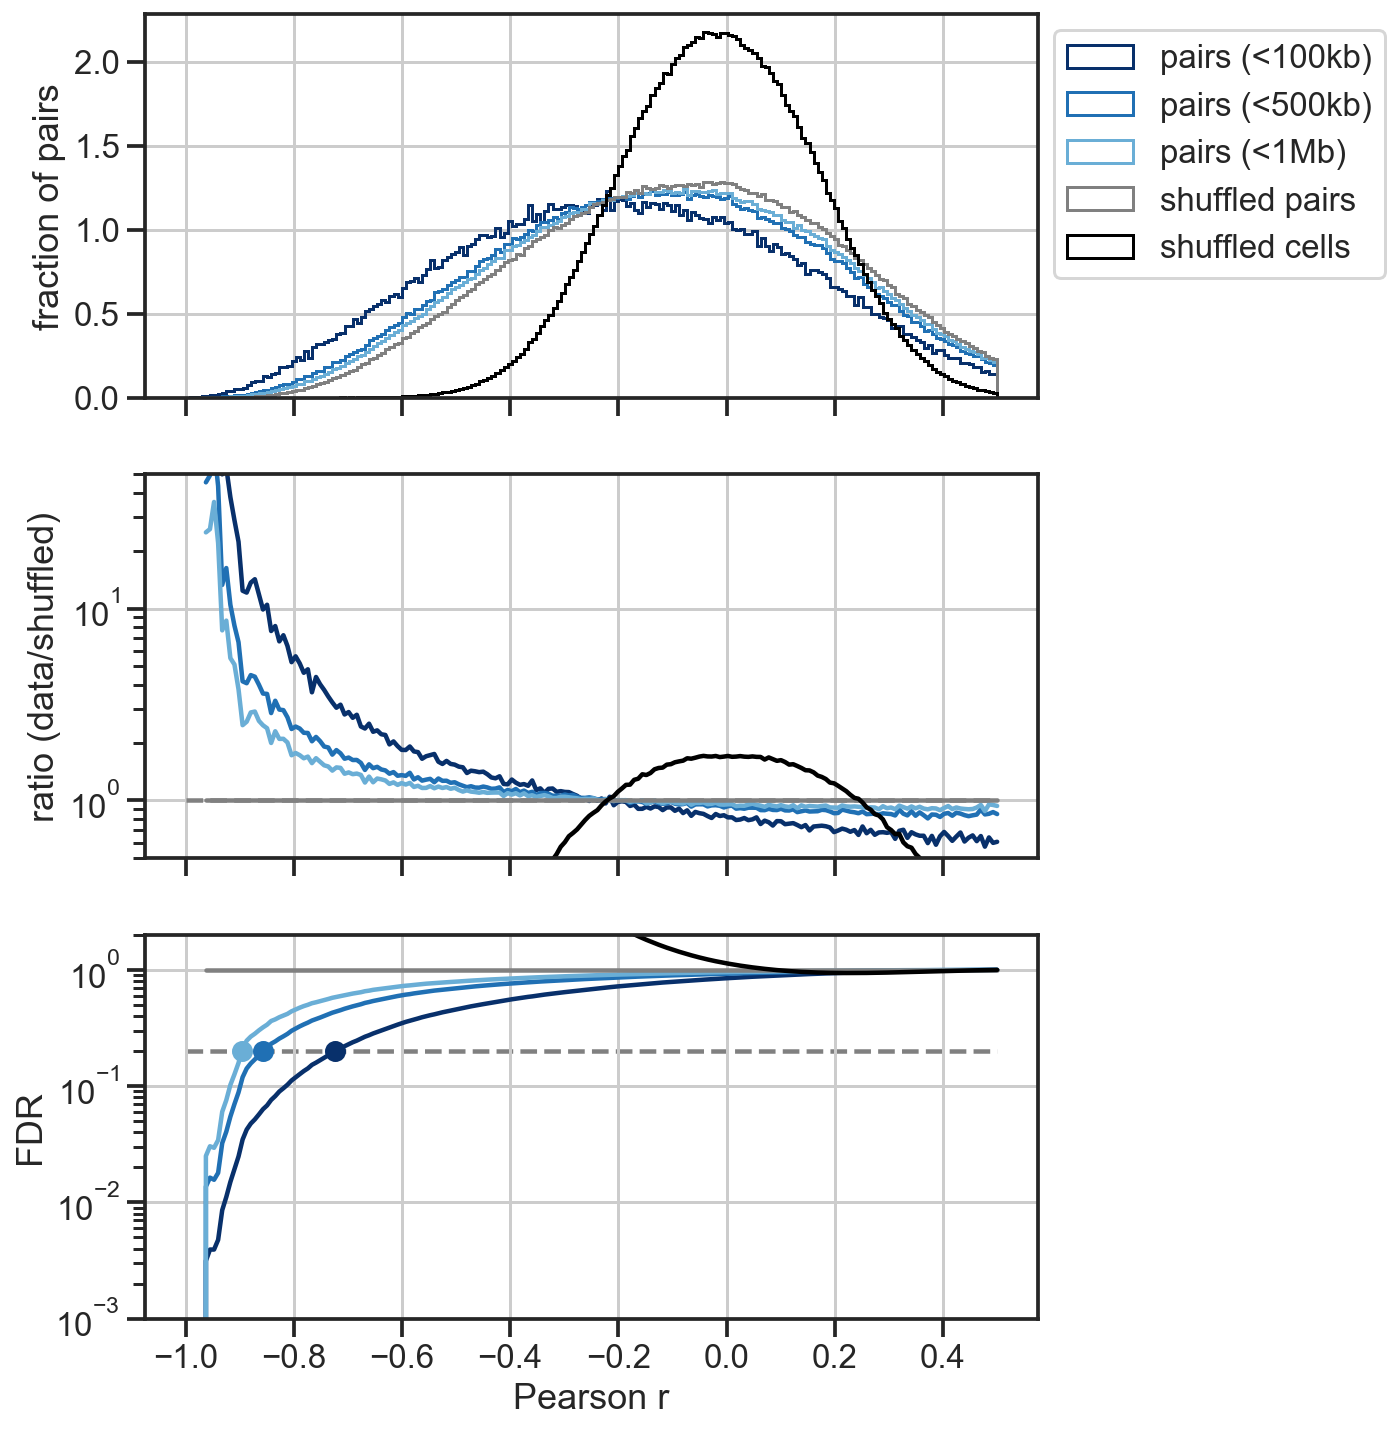

In [17]:
# figure 2
fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
# ax.set_ylim([0, 6])

ax = axs[1]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[2]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figures.format("corr_dist_plot"))
plt.show()

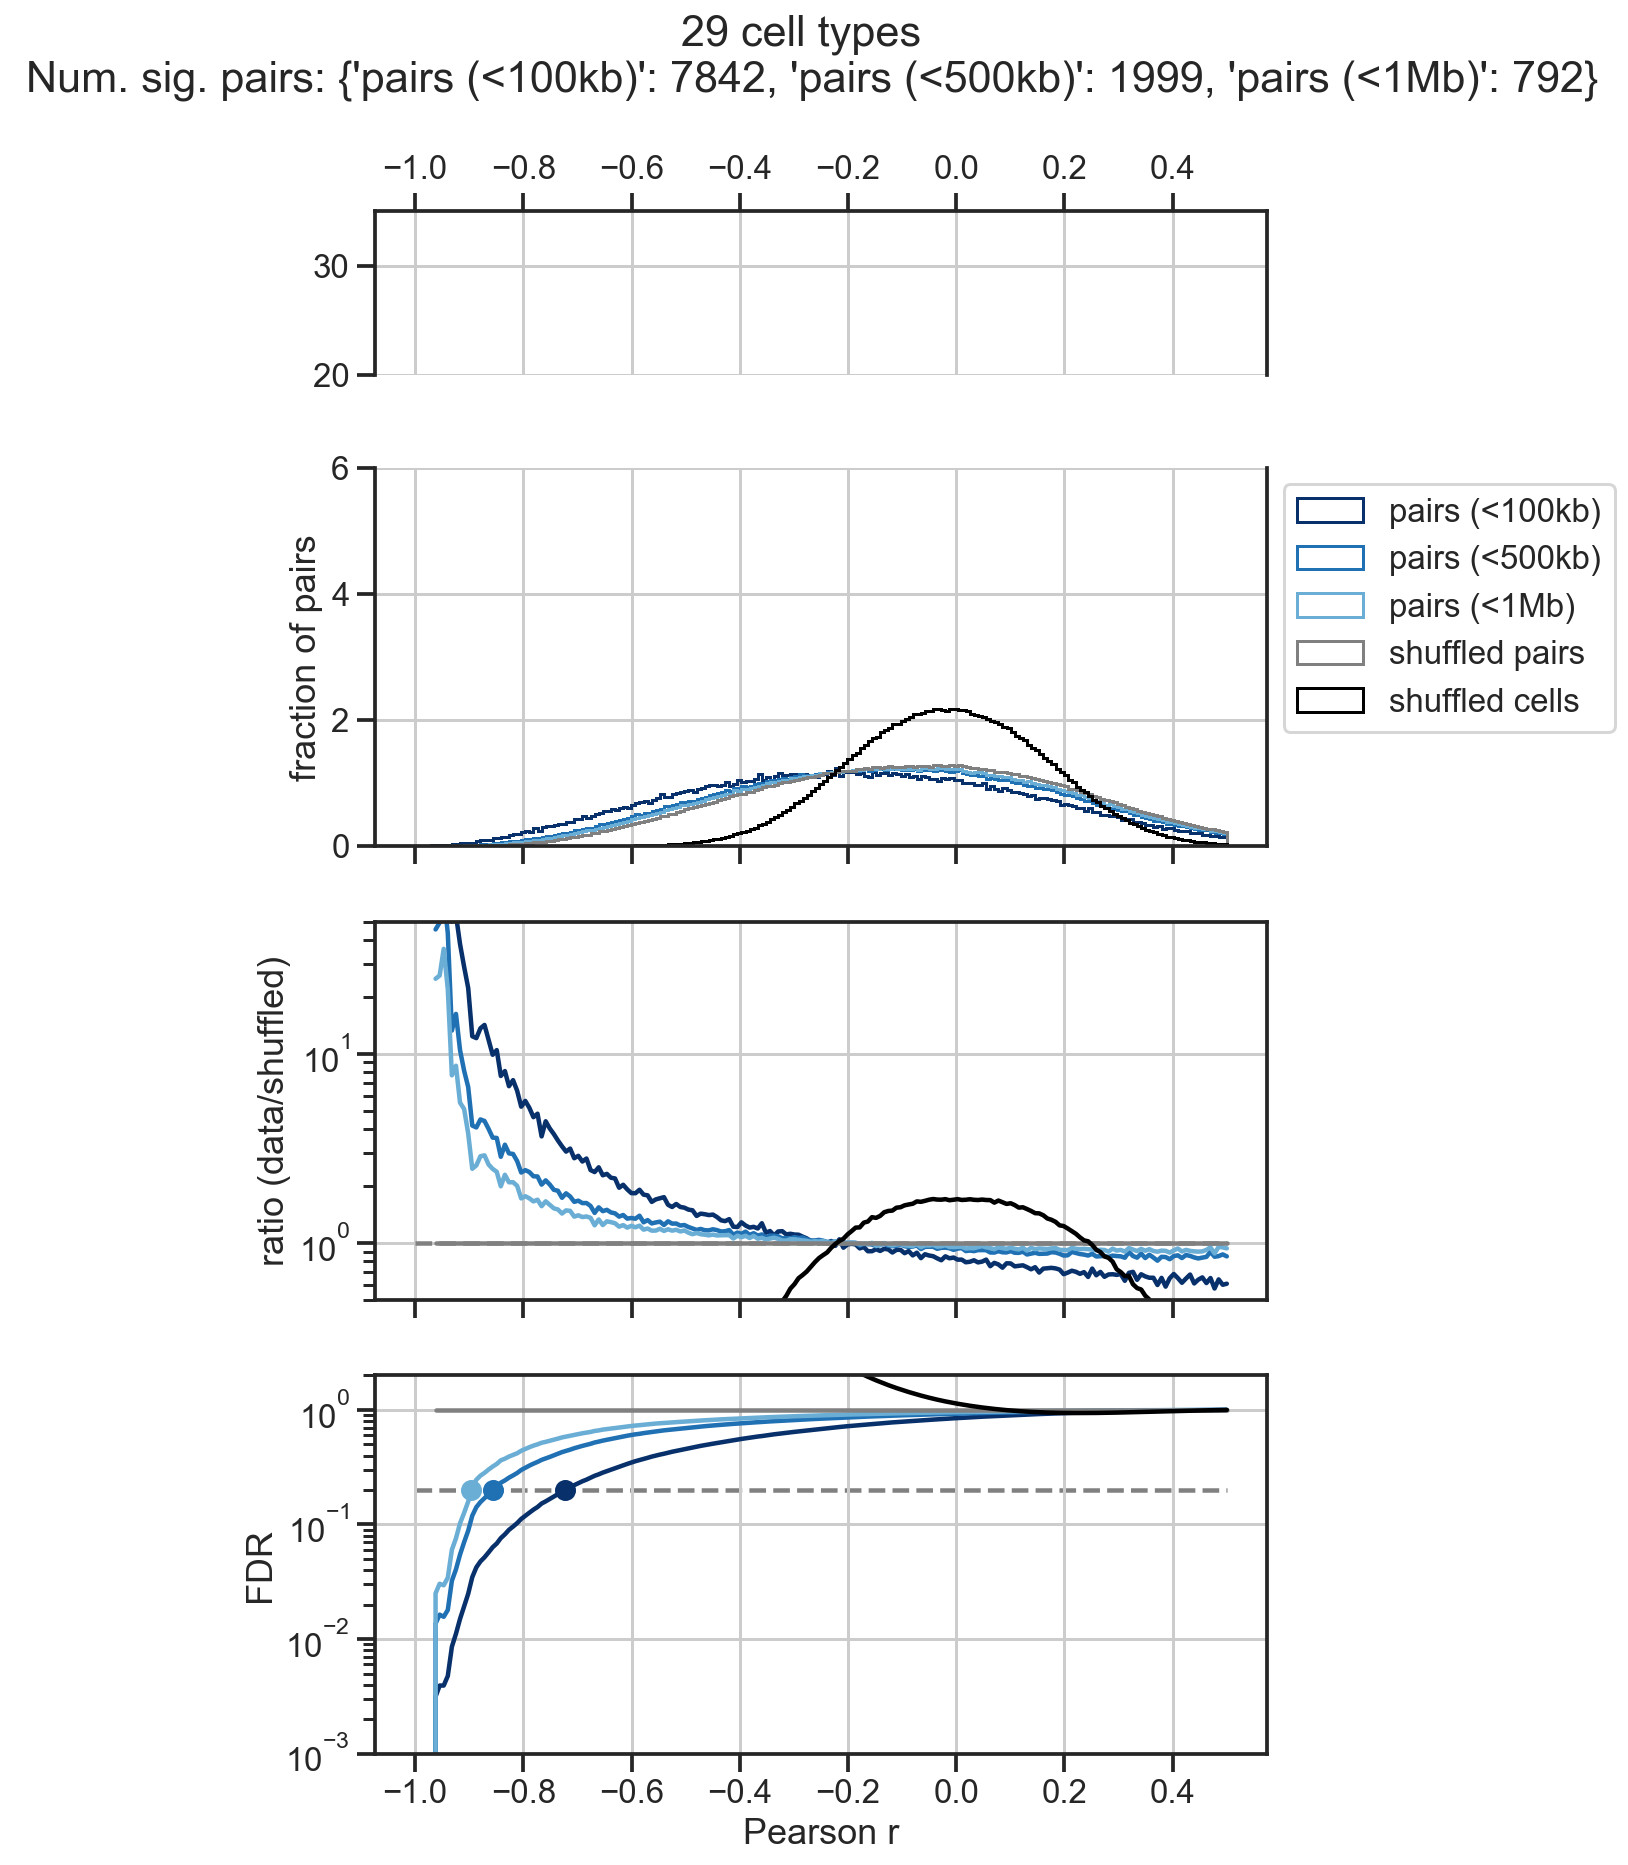

In [18]:
# figure 2
fig, axs = plt.subplots(4, 1, figsize=(4*2,4*4), sharex=True)
# fig.suptitle("k, ka = ({}, {})\n Num. sig. pairs: {}".format(k, ka, track_num_sigs), y=0.88)
fig.suptitle("29 cell types \n Num. sig. pairs: {}".format(track_num_sigs), y=0.88)

axs[0].axis('off')
ax = fig.add_subplot(912)
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.set_ylim([20, 35])
sns.despine(bottom=True, top=False, right=False, ax=ax)

ax = axs[1]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
ax.set_ylim([0, 6])
sns.despine(top=True, right=False, ax=ax)

ax = axs[2]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[3]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figures.format('corr_dist_plot_v2'))
plt.show()

# Num sig. linked pairs vs num sig. correlated pairs

In [36]:
# input: to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells    
# paras: distance_threshold


def get_r_threshold(bins, fdr, fdr_threshold, r_min, r_max):
    """given fdr function (bins, fdr) and fdr_threshold
    get r threshold
    """
    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]

    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(r_min)*f(r_max) < 0:
        sol = optimize.root_scalar(f, bracket=(r_min, r_max))
        if sol:
            r_threshold = sol.root
            
        else:
            print("failed to detect r_threshold:")
            r_threshold = np.nan 
            
    else:
        print("failed to detect r_threshold:")
        r_threshold = np.nan
        
    return r_threshold


def get_significance_stats(
    enhancer_gene_to_eval,
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
    distance_threshold=1e5, fdr_threshold=0.2,
    positive_side=False,
    ):
    """assuming significant negative correlation
    """
    r_min, r_max = -1, 0
    
    # align all to negative side
    if positive_side:
        corrs *= (-1)
        corrs_shuffled *= (-1)
        corrs_shuffled_cells *= (-1)
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values

    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]

    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    # hist_shuff
    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # hist_shuff_cells
    hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, density=True)
    cdf_shuff_cells = np.cumsum(hist_shuff_cells)
    # hist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    
    
    # fdr
    fdr_linked = cdf_shuff/(cdf+1e-7)
    fdr_correlated = cdf_shuff_cells/(cdf+1e-7)

    # get r_threshold
    r_threshold_linked = get_r_threshold(bins, fdr_linked, fdr_threshold, r_min, r_max)
    r_threshold_correlated = get_r_threshold(bins, fdr_correlated, fdr_threshold, r_min, r_max)
    
    # stats
    if ~np.isnan(r_threshold_linked):
        # all sig info
        linked_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold_linked]
        # num_sig
        num_linked_pairs = len(linked_table)
        num_linked_genes = len(linked_table['gene'].unique()) 
        num_linked_enhs = len(linked_table['ens'].unique()) 
    else:
        num_linked_pairs, num_linked_genes, num_linked_enhs = np.nan, np.nan, np.nan
    
    if ~np.isnan(r_threshold_correlated):
        # all sig info
        correlated_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold_correlated]
        # num_sig
        num_correlated_pairs = len(correlated_table)
        num_correlated_genes = len(correlated_table['gene'].unique()) 
        num_correlated_enhs = len(correlated_table['ens'].unique()) 
    else:
        num_correlated_pairs, num_correlated_genes, num_correlated_enhs = np.nan, np.nan, np.nan

    return {
            'dist_th': distance_threshold,
            'num_total_pairs': num_total_pairs,
            'num_total_genes': num_total_genes,
            'num_total_enhs': num_total_enhs,
        
            'r_th_linked': r_threshold_linked,
            'num_linked_pairs': num_linked_pairs,
            'num_linked_genes': num_linked_genes,
            'num_linked_enhs': num_linked_enhs,
        
            'r_th_correlated': r_threshold_correlated,
            'num_correlated_pairs': num_correlated_pairs,
            'num_correlated_genes': num_correlated_genes,
            'num_correlated_enhs': num_correlated_enhs,
           }

In [35]:
distance_threshold = 1e5
res = get_significance_stats(
            enhancer_gene_to_eval,
            to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
            distance_threshold=distance_threshold,
            positive_side=False,
            )
res

{'dist_th': 100000.0,
 'r_threshold': -0.7231354483727843,
 'num_total_pairs': 216315,
 'num_total_genes': 17897,
 'num_total_enhs': 89978,
 'num_sig_pairs': 7842,
 'num_sig_genes': 2495,
 'num_sig_enhs': 7083}

In [37]:
distance_threshold = 1e5
res = get_significance_stats(
            enhancer_gene_to_eval,
            to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
            distance_threshold=distance_threshold,
            positive_side=False,
            )
res

{'dist_th': 100000.0,
 'num_total_pairs': 216315,
 'num_total_genes': 17897,
 'num_total_enhs': 89978,
 'r_th_linked': -0.7231354483727843,
 'num_linked_pairs': 7842,
 'num_linked_genes': 2495,
 'num_linked_enhs': 7083,
 'r_th_correlated': -0.25774822031761485,
 'num_correlated_pairs': 90753,
 'num_correlated_genes': 14574,
 'num_correlated_enhs': 56264}

In [91]:
dist_ths = np.hstack([
    np.linspace(1e5, 1e6, 10),
    np.logspace(6, 7, 10),
])


print(dist_ths)
res_all = [] 
for dist_th in dist_ths:
    res = get_significance_stats(
                enhancer_gene_to_eval,
                to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
                distance_threshold=dist_th,
                positive_side=False,
                )
    res_all.append(res)
res_all = pd.DataFrame(res_all)

print(res_all.shape)
res_all.head()
    
    

[  100000.           200000.           300000.           400000.
   500000.           600000.           700000.           800000.
   900000.          1000000.          1000000.          1291549.66501488
  1668100.53720006  2154434.69003188  2782559.40220713  3593813.66380463
  4641588.83361278  5994842.50318941  7742636.82681128 10000000.        ]
(20, 12)


,dist_th,num_total_pairs,num_total_genes,num_total_enhs,r_th_linked,num_linked_pairs,num_linked_genes,num_linked_enhs,r_th_correlated,num_correlated_pairs,num_correlated_genes,num_correlated_enhs
0,100000.0,216315,17897,89978,-0.723135,7842,2495,7083,-0.257748,90753,14574,56264
1,200000.0,451471,18422,113901,-0.779463,5874,1823,5270,-0.268920,167123,16303,77743
2,300000.0,690284,18627,123940,-0.815475,3881,1266,3534,-0.275901,235944,17014,89734
3,400000.0,929163,18732,128791,-0.841004,2590,918,2397,-0.280998,299425,17469,97532
4,500000.0,1167083,18791,131323,-0.856202,1999,754,1864,-0.284664,360055,17694,103194


# problems: 
- can't go > 1e-6; points >1e-6 are artificial, because no pairs >= 1e6 distance are recorded
- number and fraction have some inconsistencies
       - need to employ local FDR
- add more yaxis 
    - (fraction of true positives)


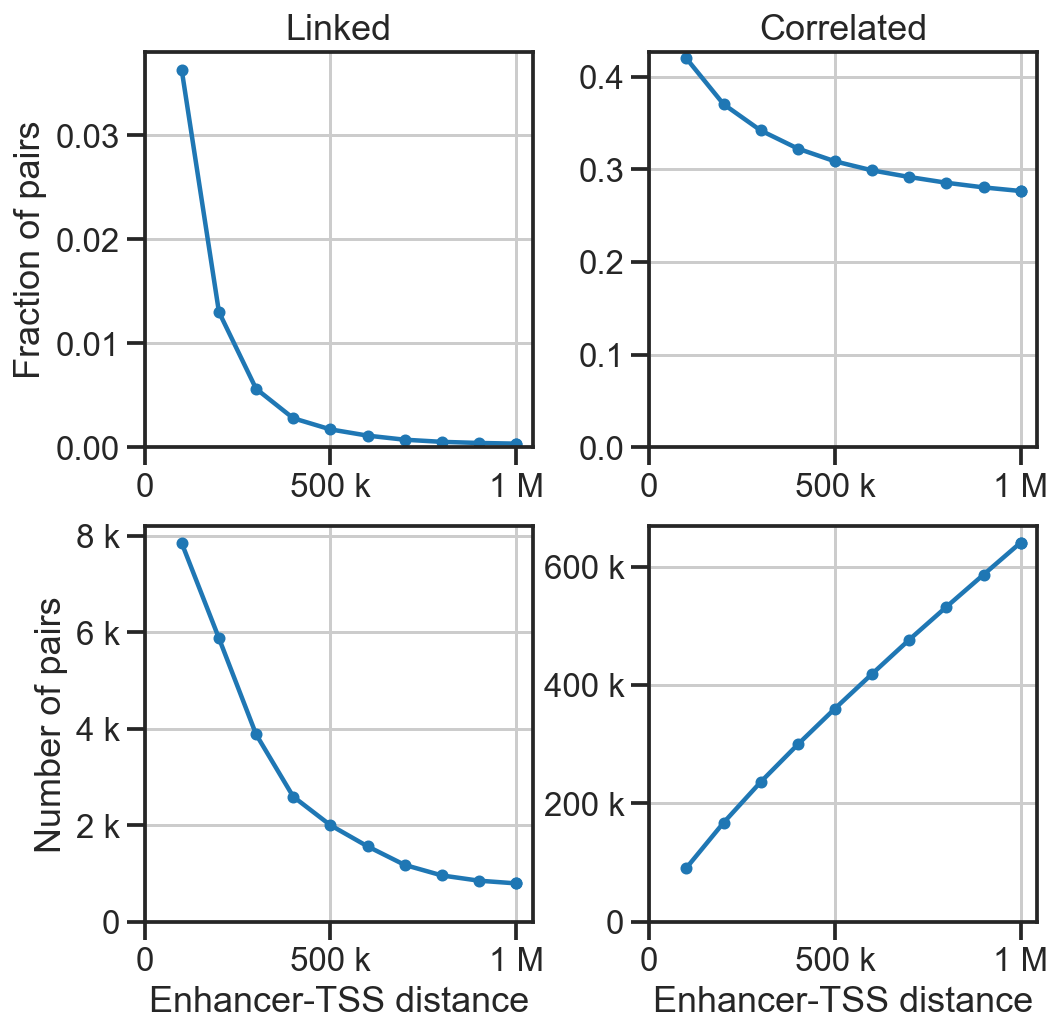

In [115]:
to_plot = res_all[res_all['dist_th']<=1e6]

ys = [
    to_plot['num_linked_pairs']/to_plot['num_total_pairs'],
    to_plot['num_correlated_pairs']/to_plot['num_total_pairs'],
    
    to_plot['num_linked_pairs'],
    to_plot['num_correlated_pairs'],
]

titles = [
    'Linked', 
    'Correlated',
]

fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2))
for i, ax in enumerate(axs.flat):
    ax.plot(to_plot['dist_th'], ys[i], 
            '-o', markersize=5)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    
    if i == 0:
        ax.set_ylabel('Fraction of pairs')
    if i < 2:
        ax.set_title(titles[i])
    if i == 2:
        ax.set_ylabel('Number of pairs')
    if i >= 2:
        ax.set_xlabel('Enhancer-TSS distance')
        ax.yaxis.set_major_formatter(mtick.EngFormatter())
        
fig.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()